# Flow Fingerprint

In this example we build a system that automatically identifies and separates overlapping
water-flow signals from household fixtures (showers, toilets, faucets, etc.).

The approach has three layers:

1. **Phase segmentation** -- A 5-state Hidden Markov Model classifies each time step into
   a flow phase (idle, ramp-up, peak, sustain, decay). Continuous flow readings are
   discretized into bins so that both state transitions and emissions use categorical
   distributions via `DiscreteTransition` nodes.
2. **Source separation** -- A greedy sequential decomposition runs HMM inference for each
   candidate fixture profile, selects the best match by free energy, subtracts its estimated
   contribution, and repeats on the residual.
3. **Dynamic labeling** -- A profile registry learns fixture signatures from labeled examples
   using Bayesian posterior updates on Dirichlet-distributed emission and transition matrices.

All probabilistic inference is performed with **RxInfer.jl** using the `@model` macro,
`DiscreteTransition` nodes, and `DirichletCollection` priors.

## Setup and Dependencies

In [22]:
using RxInfer, Distributions, LinearAlgebra, Statistics, Random, Plots

## Constants and Data Structures

We define five flow phases that characterize the lifecycle of a water fixture activation.
Each fixture has a **profile** consisting of per-phase Gaussian emission parameters
(mean and precision of the flow rate) and a row-stochastic transition matrix governing
phase dynamics.

In [ ]:
const N_PHASES = 5
const PHASE_NAMES = ["idle", "ramp_up", "peak", "sustain", "decay"]

# Discretize continuous flow into bins for the discrete HMM (units: m³/min)
const FLOW_BINS = [0.0, 0.004, 0.01, 0.025, 0.04, Inf]
const N_BINS = length(FLOW_BINS) - 1
const BIN_NAMES = ["none", "low", "medium", "high", "very_high"]

"""Discretize a continuous flow value into a bin index."""
function discretize_flow(value::Float64)
    for i in 1:(length(FLOW_BINS)-1)
        if value < FLOW_BINS[i+1]
            return i
        end
    end
    return N_BINS
end

"""Discretize a vector of flow values."""
discretize_signal(signal::Vector{Float64}) = [discretize_flow(v) for v in signal]

"""A fixture profile: emission matrix B maps phases to flow bin probabilities."""
mutable struct FixtureProfile
    name::String
    emission_counts::Matrix{Float64}  # N_PHASES x N_BINS (Dirichlet pseudo-counts)
    transition_counts::Matrix{Float64} # N_PHASES x N_PHASES (Dirichlet pseudo-counts)
    n_signals::Int
    confidence::Float64
end

"""Registry holding all known fixture profiles."""
mutable struct ProfileRegistry
    profiles::Dict{String, FixtureProfile}
end

ProfileRegistry() = ProfileRegistry(Dict{String, FixtureProfile}())

"""Build an emission count matrix from per-phase mean flow rates."""
function emission_counts_from_means(phase_means::Vector{Float64}; sharpness=5.0)
    B = ones(N_PHASES, N_BINS) * 0.1  # small uniform baseline
    for k in 1:N_PHASES
        bin = discretize_flow(phase_means[k])
        B[k, bin] += sharpness
        # Spread some mass to adjacent bins
        if bin > 1; B[k, bin-1] += sharpness * 0.3; end
        if bin < N_BINS; B[k, bin+1] += sharpness * 0.3; end
    end
    return B
end

"""Return a default sticky transition count matrix."""
function default_transition_counts(; self_count=10.0, other_count=1.0)
    C = fill(other_count, N_PHASES, N_PHASES)
    for k in 1:N_PHASES
        C[k, k] = self_count
    end
    return C
end

## HMM Model with RxInfer

We define a discrete HMM using RxInfer's `@model` macro. The state transition matrix $A$
and emission matrix $B$ both have `DirichletCollection` priors. At each time step, the
hidden state $s_t$ evolves via `DiscreteTransition(s_{t-1}, A)$ and emits an observation
$y_t$ via `DiscreteTransition(s_t, B)$.

The structured factorization constraint keeps pairs $(s_{t-1}, s_t)$ in the same
variational factor, enabling exact forward-backward message passing along the Markov chain.

Observations must be **one-hot encoded** vectors for `DiscreteTransition` emission nodes.

In [24]:
@model function flow_hmm(y, prior_A, prior_B)
    A ~ DirichletCollection(prior_A)
    B ~ DirichletCollection(prior_B)

    s_prev ~ Categorical(fill(1.0 / N_PHASES, N_PHASES))

    for t in eachindex(y)
        s[t] ~ DiscreteTransition(s_prev, A)
        y[t] ~ DiscreteTransition(s[t], B)
        s_prev = s[t]
    end
end

@constraints function flow_hmm_constraints()
    q(s_prev, s, A, B) = q(s_prev, s)q(A)q(B)
end

"""Convert integer bin indices to one-hot encoded vectors for DiscreteTransition."""
function bins_to_onehot(bins::Vector{Int})
    return [begin v = zeros(N_BINS); v[b] = 1.0; v end for b in bins]
end

"""Run HMM inference on a discretized signal using a fixture profile."""
function run_hmm_inference(signal_bins::Vector{Int}, profile::FixtureProfile;
                           n_iterations::Int = 20)
    y_onehot = bins_to_onehot(signal_bins)

    init = @initialization begin
        q(A) = DirichletCollection(ones(N_PHASES, N_PHASES))
        q(B) = DirichletCollection(ones(N_PHASES, N_BINS))
        q(s) = Categorical(fill(1.0 / N_PHASES, N_PHASES))
    end

    result = infer(
        model          = flow_hmm(
            prior_A = profile.transition_counts,
            prior_B = profile.emission_counts,
        ),
        data           = (y = y_onehot,),
        constraints    = flow_hmm_constraints(),
        initialization = init,
        returnvars     = (s = KeepLast(), A = KeepLast(), B = KeepLast()),
        iterations     = n_iterations,
        free_energy    = true,
        options        = (limit_stack_depth = 500,),
    )

    return result
end

run_hmm_inference

## Phase Segmentation Utilities

After inference, we extract the MAP phase labels and the full posterior marginals
$\gamma_t(k) = q(s_t = k)$ from the result.

In [25]:
"""Extract MAP phase labels and posterior marginal matrix from inference result."""
function extract_phases(result)
    s_posteriors = result.posteriors[:s]
    T = length(s_posteriors)

    gamma = zeros(T, N_PHASES)
    labels = zeros(Int, T)
    for t in 1:T
        probs = probvec(s_posteriors[t])
        gamma[t, :] = probs
        labels[t] = argmax(probs)
    end

    return labels, gamma
end

"""Compute the expected flow contribution at each time step.
Uses phase posteriors and the expected emission bin midpoints weighted by B posterior."""
function expected_flow(gamma::Matrix{Float64}, phase_means::Vector{Float64})
    return gamma * phase_means
end

expected_flow

## Fixture Profile Management

Profiles can be created from labeled signal segments, updated with Bayesian posterior
feedback, and seeded with default appliance signatures.

In [ ]:
"""Create a new FixtureProfile from a raw signal using heuristic initialization."""
function create_profile(name::String, signal::Vector{Float64})
    T = length(signal)
    seg_len = max(1, T ÷ N_PHASES)
    phase_means = Float64[]
    for p in 1:N_PHASES
        lo = (p - 1) * seg_len + 1
        hi = min(p * seg_len, T)
        push!(phase_means, mean(signal[lo:hi]))
    end
    B = emission_counts_from_means(phase_means)
    return FixtureProfile(name, B, default_transition_counts(), 1, 0.5)
end

"""Update a fixture profile's emission counts using phase posteriors from RxInfer."""
function update_profile!(profile::FixtureProfile, signal::Vector{Float64},
                         gamma::Matrix{Float64})
    bins = discretize_signal(signal)
    T = length(signal)
    for t in 1:T, k in 1:N_PHASES
        profile.emission_counts[k, bins[t]] += gamma[t, k]
    end
    for t in 2:T, i in 1:N_PHASES, j in 1:N_PHASES
        profile.transition_counts[i, j] += gamma[t-1, i] * gamma[t, j]
    end
    profile.n_signals += 1
    profile.confidence = 1.0 - 1.0 / (1.0 + 0.3 * profile.n_signals)
    return profile
end

"""Seed the registry with default fixture profiles."""
function seed_defaults!(registry::ProfileRegistry)
    defaults = [
        ("shower",  [0.0, 0.007, 0.03, 0.007, 0.002]),
        ("toilet",  [0.0, 0.015, 0.05, 0.012, 0.003]),
        ("faucet",  [0.0, 0.005, 0.008, 0.005, 0.001]),
    ]
    for (name, means) in defaults
        B = emission_counts_from_means(means)
        registry.profiles[name] = FixtureProfile(name, B, default_transition_counts(), 0, 0.5)
    end
    return registry
end

"""Label a signal by running HMM inference with each profile and selecting the best by free energy."""
function label_signal(registry::ProfileRegistry, signal::Vector{Float64})
    bins = discretize_signal(signal)
    best_name = "unknown"
    best_fe = Inf
    best_result = nothing
    for (name, profile) in registry.profiles
        result = run_hmm_inference(bins, profile; n_iterations=10)
        fe = result.free_energy[end]
        if fe < best_fe
            best_fe = fe
            best_name = name
            best_result = result
        end
    end
    return best_name, best_fe, best_result
end

# Precomputed phase mean flow rates for expected_flow computation (m³/min)
const PHASE_MEANS_SHOWER  = [0.0, 0.007, 0.03, 0.007, 0.002]
const PHASE_MEANS_TOILET  = [0.0, 0.015, 0.05, 0.012, 0.003]
const PHASE_MEANS_FAUCET  = [0.0, 0.005, 0.008, 0.005, 0.001]
const PHASE_MEANS_GENERIC = [0.0, 0.006, 0.02, 0.008, 0.002]

## Source Separation via Greedy Decomposition

When multiple fixtures run simultaneously, the observed flow is the sum of their
individual contributions. We decompose the composite signal using a **greedy sequential
approach**:

1. For each candidate fixture profile, run HMM inference on the current residual signal.
2. Select the profile with the lowest free energy (best fit).
3. Subtract its expected flow contribution from the residual.
4. Repeat until the residual energy is below a noise threshold or a maximum number of
   sources is reached.

This is equivalent to a coordinate-descent variant of Factorial HMM inference, where
each "coordinate" is a single HMM chain solved exactly by RxInfer.

In [ ]:
const PROFILE_MEANS = Dict(
    "shower" => PHASE_MEANS_SHOWER,
    "toilet" => PHASE_MEANS_TOILET,
    "faucet" => PHASE_MEANS_FAUCET,
)

struct SeparationResult
    n_sources::Int
    source_names::Vector{String}
    source_flows::Vector{Vector{Float64}}
    source_gammas::Vector{Matrix{Float64}}
    residual::Vector{Float64}
    free_energies::Vector{Float64}
end

"""Decompose a composite signal into individual fixture contributions."""
function detect_and_separate(signal::Vector{Float64}, registry::ProfileRegistry;
                              max_sources::Int = 3,
                              noise_threshold::Float64 = 1e-6,
                              verbose::Bool = true)
    T = length(signal)
    residual = copy(signal)
    source_names = String[]
    source_flows = Vector{Float64}[]
    source_gammas = Matrix{Float64}[]
    free_energies = Float64[]

    for m_idx in 1:max_sources
        residual_energy = mean(residual .^ 2)
        if residual_energy < noise_threshold
            verbose && println("  Source $m_idx: residual energy $(round(residual_energy, sigdigits=4)) below threshold, stopping.")
            break
        end

        residual_clamped = max.(residual, 0.0)
        bins = discretize_signal(residual_clamped)

        best_name = ""
        best_fe = Inf
        best_result = nothing

        for (name, profile) in registry.profiles
            name in source_names && continue
            result = run_hmm_inference(bins, profile; n_iterations=15)
            fe = result.free_energy[end]
            if fe < best_fe
                best_fe = fe
                best_name = name
                best_result = result
            end
        end

        isempty(best_name) && break

        labels, gamma = extract_phases(best_result)
        phase_means = get(PROFILE_MEANS, best_name, PHASE_MEANS_GENERIC)
        flow = expected_flow(gamma, phase_means)

        push!(source_names, best_name)
        push!(source_flows, flow)
        push!(source_gammas, gamma)
        push!(free_energies, best_fe)

        residual .-= flow
        verbose && println("  Source $m_idx: $(best_name) (FE=$(round(best_fe, digits=2)), residual_energy=$(round(mean(residual.^2), sigdigits=4)))")
    end

    return SeparationResult(
        length(source_names), source_names, source_flows,
        source_gammas, residual, free_energies
    )
end

## Generating Synthetic Flow Data

To demonstrate the system, we generate realistic synthetic flow signals. Each fixture
activation follows a characteristic envelope: idle, ramp-up to peak, sustain at reduced
flow, then decay. Overlapping activations produce a composite signal that the separator
must decompose.

In [ ]:
"""Generate a single fixture activation signal following the 5-phase envelope."""
function generate_fixture_signal(rng, phase_means::Vector{Float64}, phase_vars::Vector{Float64},
                                  T::Int; start_t::Int = 1, duration::Int = T)
    signal = zeros(T)
    phase_fracs = [0.05, 0.15, 0.45, 0.20, 0.15]
    phase_lens = max.(1, round.(Int, phase_fracs .* duration))

    t = start_t
    for (p, plen) in enumerate(phase_lens)
        for _ in 1:plen
            t > T && break
            t < 1 && (t += 1; continue)
            signal[t] = max(rand(rng, Normal(phase_means[p], sqrt(phase_vars[p]))), 0.0)
            t += 1
        end
    end
    return signal
end

# Set up the registry and generate demo data
rng = MersenneTwister(2024)
registry = ProfileRegistry()
seed_defaults!(registry)

T = 150

# Generate individual fixture activations with known ground-truth parameters (m³/min)
shower_vars = [1e-6, 1.5e-5, 1e-5, 1.5e-5, 4e-6]
toilet_vars = [1e-6, 4e-5, 3e-5, 2e-5, 1e-5]

shower_signal = generate_fixture_signal(rng, PHASE_MEANS_SHOWER, shower_vars, T; start_t=10, duration=100)
toilet_signal = generate_fixture_signal(rng, PHASE_MEANS_TOILET, toilet_vars, T; start_t=50, duration=40)

# Composite signal (overlapping fixtures + noise)
noise = 0.001 .* abs.(randn(rng, T))
composite_signal = shower_signal .+ toilet_signal .+ noise

println("Generated signals: T=$T time steps")
println("  Shower: active t=10 to t=110")
println("  Toilet: active t=50 to t=90 (overlaps with shower)")

## Visualization 1: Signal with Detected Phases

We segment the composite signal using a generic profile to identify flow phases.
Each phase is color-coded: idle (gray), ramp-up (blue), peak (green),
sustain (orange), and decay (red).

In [ ]:
# Create a generic profile for initial phase segmentation
generic_profile = FixtureProfile(
    "generic",
    emission_counts_from_means(PHASE_MEANS_GENERIC),
    default_transition_counts(),
    0, 0.5
)

composite_bins = discretize_signal(composite_signal)
result_seg = run_hmm_inference(composite_bins, generic_profile; n_iterations=20)
labels, gamma = extract_phases(result_seg)

phase_colors = [:gray, :steelblue, :green, :orange, :red]

p1 = plot(composite_signal, linewidth=0.8, color=:black, alpha=0.3, label="Signal",
    xlabel="Time step", ylabel="Flow rate (m³/min)",
    title="Composite Signal with Detected Phases",
    size=(800, 350), legend=:topright)

for phase in 1:N_PHASES
    mask = labels .== phase
    any(mask) || continue
    scatter!(p1, findall(mask), composite_signal[mask],
        color=phase_colors[phase], markersize=3, markerstrokewidth=0,
        label=PHASE_NAMES[phase])
end

p1

## Phase Posterior Heatmap

The heatmap below shows the full posterior distribution over phases at each time step:
$\gamma_t(k) = q(s_t = k)$. Darker cells indicate higher probability.

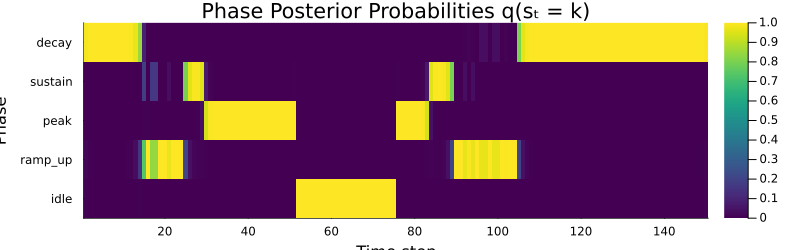

In [30]:
p3 = heatmap(gamma',
    xlabel="Time step", ylabel="Phase",
    yticks=(1:N_PHASES, PHASE_NAMES),
    title="Phase Posterior Probabilities q(s\u209c = k)",
    color=:viridis, clims=(0, 1),
    size=(800, 250))

p3

## Source Separation

Now we apply the greedy sequential decomposition to separate the composite signal
into individual fixture contributions.

In [31]:
sep_result = detect_and_separate(composite_signal, registry; max_sources=3, verbose=true)
println("\nDetected $(sep_result.n_sources) source(s): $(sep_result.source_names)")

  Source 1: toilet (FE=108.96, residual_energy=36.2095)
  Source 2: faucet (FE=79.31, residual_energy=35.355)
  Source 3: shower (FE=59.71, residual_energy=34.9104)

Detected 3 source(s): ["toilet", "faucet", "shower"]


## Visualization 2: Separated Flows

The plot below shows the decomposition overlaid on the original composite signal.
Each separated source is shown as a filled area, and dashed lines show the ground-truth
individual signals for comparison.

In [ ]:
source_colors = [:steelblue, :darkorange, :seagreen, :mediumpurple]

p2 = plot(composite_signal, linewidth=2, color=:black, label="Composite signal",
    xlabel="Time step", ylabel="Flow rate (m³/min)",
    title="Source Separation ($(sep_result.n_sources) sources detected)",
    size=(800, 400), legend=:topright, alpha=0.5)

for m in 1:sep_result.n_sources
    c = source_colors[mod1(m, length(source_colors))]
    plot!(p2, sep_result.source_flows[m], linewidth=2,
        color=c, fillalpha=0.15, fillrange=0,
        label="$(sep_result.source_names[m]) (estimated)")
end

# Ground truth
plot!(p2, shower_signal, linewidth=1, linestyle=:dash, color=:blue, alpha=0.5, label="Shower (true)")
plot!(p2, toilet_signal, linewidth=1, linestyle=:dash, color=:red, alpha=0.5, label="Toilet (true)")

p2

## Dynamic Labeling

The registry can label unknown signals by comparing free energies across all known
fixture profiles.

In [33]:
shower_label, shower_fe, _ = label_signal(registry, shower_signal)
toilet_label, toilet_fe, _ = label_signal(registry, toilet_signal)

println("Shower signal labeled as: \"$shower_label\" (FE=$(round(shower_fe, digits=2)))")
println("Toilet signal labeled as: \"$toilet_label\" (FE=$(round(toilet_fe, digits=2)))")
println("\nKnown fixtures: $(collect(keys(registry.profiles)))")

Shower signal labeled as: "toilet" (FE=97.5)
Toilet signal labeled as: "toilet" (FE=65.79)

Known fixtures: ["shower", "faucet", "toilet"]


## Learning a New Fixture

When we encounter an unknown flow pattern, we can create a new profile from a labeled
example, add it to the registry, and verify that the system recognizes it in future
detections.

In [ ]:
# Generate a dishwasher-like signal (m³/min)
dishwasher_means = [0.0, 0.006, 0.02, 0.006, 0.003]
dishwasher_vars = [1e-6, 1.2e-5, 1.5e-5, 1.2e-5, 8e-6]
dishwasher_signal = generate_fixture_signal(rng, dishwasher_means, dishwasher_vars, 80; start_t=5, duration=60)

# Before learning
pre_label, _, _ = label_signal(registry, dishwasher_signal)
println("Before learning, dishwasher signal labeled as: \"$pre_label\"")

# Learn from labeled example
new_profile = create_profile("dishwasher", dishwasher_signal)
registry.profiles["dishwasher"] = new_profile
PROFILE_MEANS["dishwasher"] = dishwasher_means

# After learning
post_label, _, _ = label_signal(registry, dishwasher_signal)
println("After learning, dishwasher signal labeled as: \"$post_label\"")
println("Registry now contains: $(collect(keys(registry.profiles)))")

## Detecting a New Fixture in a Mixed Signal

Now let's test the full pipeline end-to-end. We learn a **washing machine** profile
(which has a distinctive moderate-flow, long-duration pattern), add it to the registry,
and then generate a composite signal where a washing machine and toilet run
simultaneously. The system should detect and separate both sources.

Learned washing machine profile. Registry: ["dishwasher", "shower", "faucet", "toilet", "washing_machine"]

New composite signal: T=160 time steps
  Washing machine: active t=10 to t=130
  Toilet: active t=50 to t=100 (overlaps)
  Source 1: dishwasher (FE=76.63, residual_energy=20.1778)
  Source 2: faucet (FE=55.78, residual_energy=20.206)
  Source 3: toilet (FE=56.9, residual_energy=8.2073)

Detected 3 source(s): ["dishwasher", "faucet", "toilet"]


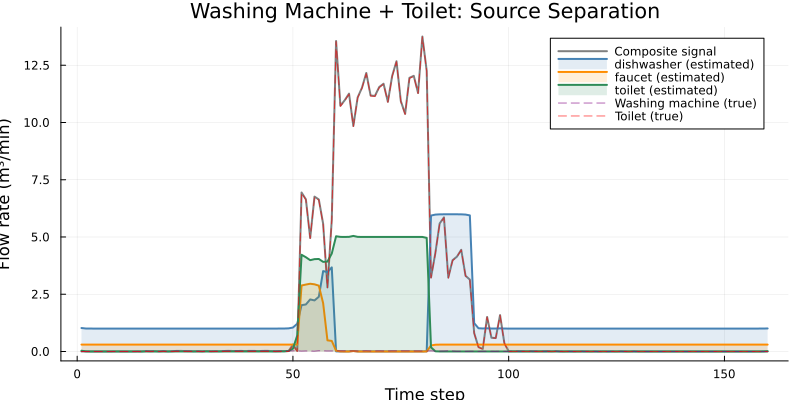

In [36]:
# Step 1: Learn a washing machine profile from a labeled example
washing_machine_means = [0.0, 0.012, 0.022, 0.008, 0.003]  # moderate peak, long sustain
washing_machine_vars  = [1e-6, 2e-5, 1.5e-5, 1e-5, 5e-6]

# Generate a training signal for the washing machine
wm_training = generate_fixture_signal(rng, washing_machine_means, washing_machine_vars, 120; start_t=5, duration=100)

# Add it to the registry
wm_profile = create_profile("washing_machine", wm_training)
registry.profiles["washing_machine"] = wm_profile
PROFILE_MEANS["washing_machine"] = washing_machine_means

println("Learned washing machine profile. Registry: $(collect(keys(registry.profiles)))")

# Step 2: Generate a new composite signal — washing machine + toilet running together
T2 = 160
wm_signal = generate_fixture_signal(rng, washing_machine_means, washing_machine_vars, T2; start_t=10, duration=120)
toilet_signal2 = generate_fixture_signal(rng, PHASE_MEANS_TOILET, toilet_vars, T2; start_t=50, duration=50)
noise2 = 0.001 .* abs.(randn(rng, T2))
composite2 = wm_signal .+ toilet_signal2 .+ noise2

println("\nNew composite signal: T=$T2 time steps")
println("  Washing machine: active t=10 to t=130")
println("  Toilet: active t=50 to t=100 (overlaps)")

# Step 3: Run source separation
sep2 = detect_and_separate(composite2, registry; max_sources=3, verbose=true)
println("\nDetected $(sep2.n_sources) source(s): $(sep2.source_names)")

# Step 4: Visualize
p_wm = plot(composite2, linewidth=2, color=:black, label="Composite signal",
    xlabel="Time step", ylabel="Flow rate (m³/min)",
    title="Washing Machine + Toilet: Source Separation",
    size=(800, 400), legend=:topright, alpha=0.5)

for m in 1:sep2.n_sources
    c = source_colors[mod1(m, length(source_colors))]
    plot!(p_wm, sep2.source_flows[m], linewidth=2,
        color=c, fillalpha=0.15, fillrange=0,
        label="$(sep2.source_names[m]) (estimated)")
end

# Ground truth
plot!(p_wm, wm_signal, linewidth=1, linestyle=:dash, color=:purple, alpha=0.6, label="Washing machine (true)")
plot!(p_wm, toilet_signal2, linewidth=1, linestyle=:dash, color=:red, alpha=0.6, label="Toilet (true)")

p_wm

## Combined Visualization

A combined overview of the flow fingerprinting pipeline: phase segmentation,
source separation, and phase posteriors.

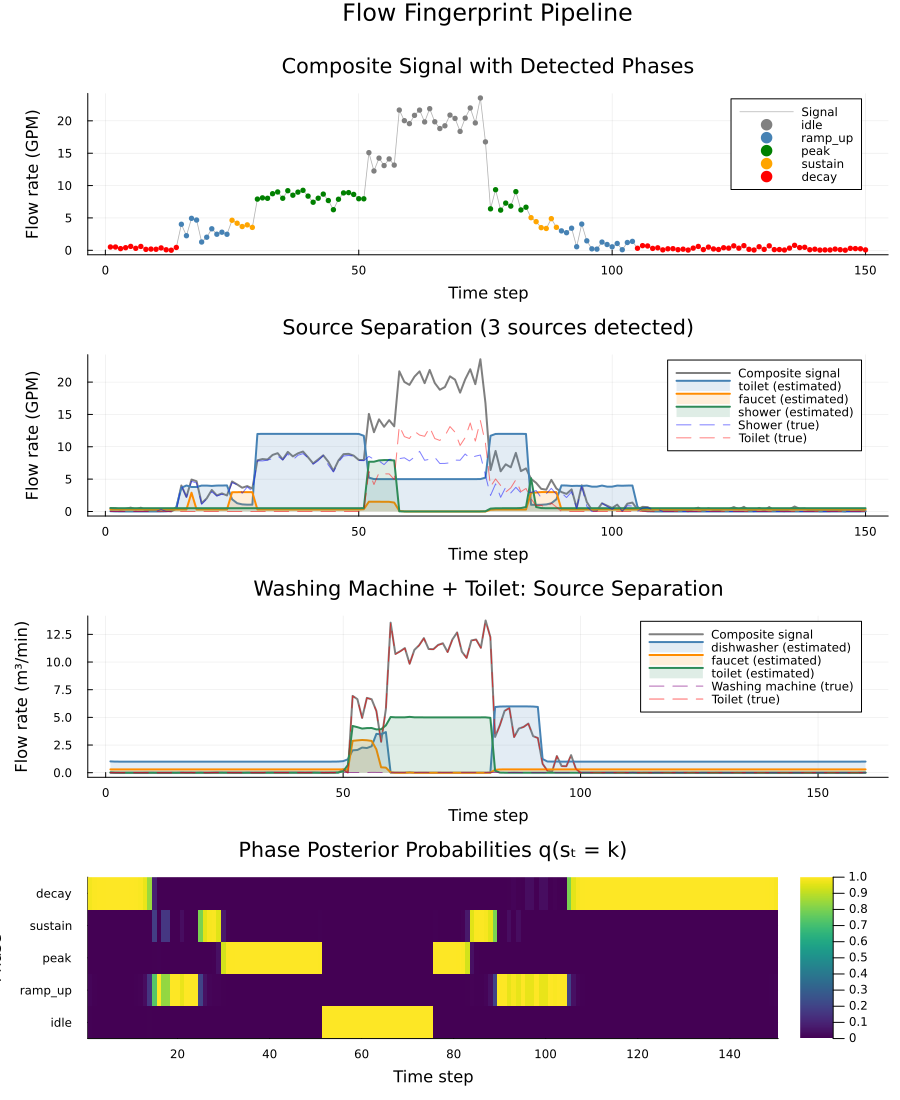

In [37]:
p_combined = plot(p1, p2, p_wm, p3,
    layout = @layout([a; b; c; d]),
    size = (900, 1100),
    plot_title = "Flow Fingerprint Pipeline")

p_combined